# Please install the following python libraries
- python3: https://www.python.org/
- numpy: https://numpy.org/install/
- tqdm: https://github.com/tqdm/tqdm#installation
- matplotlib: https://matplotlib.org/stable/users/installing/index.html
- Starter Code was tested on Python 3.11.11

If you encounter the error: "IProgress not found. Please update jupyter & ipywidgets"
    
Please install the ipywidgets as follows:

    with pip, do
    - pip install ipywidgets
    
    with conda, do
    - conda install -c conda-forge ipywidgets
    
Restart your notebook 

In [166]:
import numpy as np
import random
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from typing import Tuple

In [167]:
"""Here is the implementation of the 10-armed Bandit problem/testbed. DO NOT CHANGE 
   Note that:
       - call the reset function whenever you want to generate a new 10-armed Bandit problem
"""
class Bandit(object):
    def __init__(self, k=10):
        # Number of the actions
        self.k = k

        # Numpy array to store the true action value the k arms/actions
        self.q_star = np.empty(self.k)

    def reset(self):
        # Reset the true action values to generate a new k-armed bandit problem
        # Value for each arm is randomly sampled from a normal distribution 
        # with mean = 0, variance = 1.0. 
        self.q_star = np.random.normal(loc=0, scale=1, size=self.k)
        
    def best_action(self):
        """Return the indices of all best actions/arms in a list variable
        """
        return np.where(self.q_star == self.q_star.max())[0].tolist()  

    def step(self, act):
        """
        Args:
            act (int): index of the action
        """
        # Compute the reward for each action
        # The reward for each action at time step t is sampled from a Gaussian distribution
        # For the k-th arm, the mean = q_star[k] (true value) and variance = 1
        rewards = np.random.normal(loc=self.q_star, scale=np.ones(self.k), size=self.k)
        return rewards[act]

In [168]:
"""Here is the plotting function you can directly use to plot the figures needed for Q5 and Q6
"""

# plot function
def plot_curves(arr_list, legend_list, color_list, upper_bound, ylabel):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        upper_bound (numpy array): array contains the best possible rewards for 2000 runs. the shape should be (2000,)
        ylabel (string): label of the Y axis
        
        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly. 
        Do not forget to change the ylabel for different plots.
        
        To plot the upper bound for % Optimal action figure, set upper_bound = np.ones(num_step), where num_step is the number of steps.
    """
    # set the figure type
    plt.clf()
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Steps")
    ax.set_ylim(-0.1, upper_bound.mean() + 0.1)
    
    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        print(arr[0])
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err = 1.96 * arr_err
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3, color=color)
        # save the plot handle
        h_list.append(h) 
    
    # plot the upper bound
    h = plt.axhline(y=upper_bound.mean(), color='k', linestyle='--', label="upper bound")
    h_list.append(h)
    
    # plot legends
    ax.legend(handles=h_list)  
    plt.show()

# Q1: Implement 10-armed Bandit

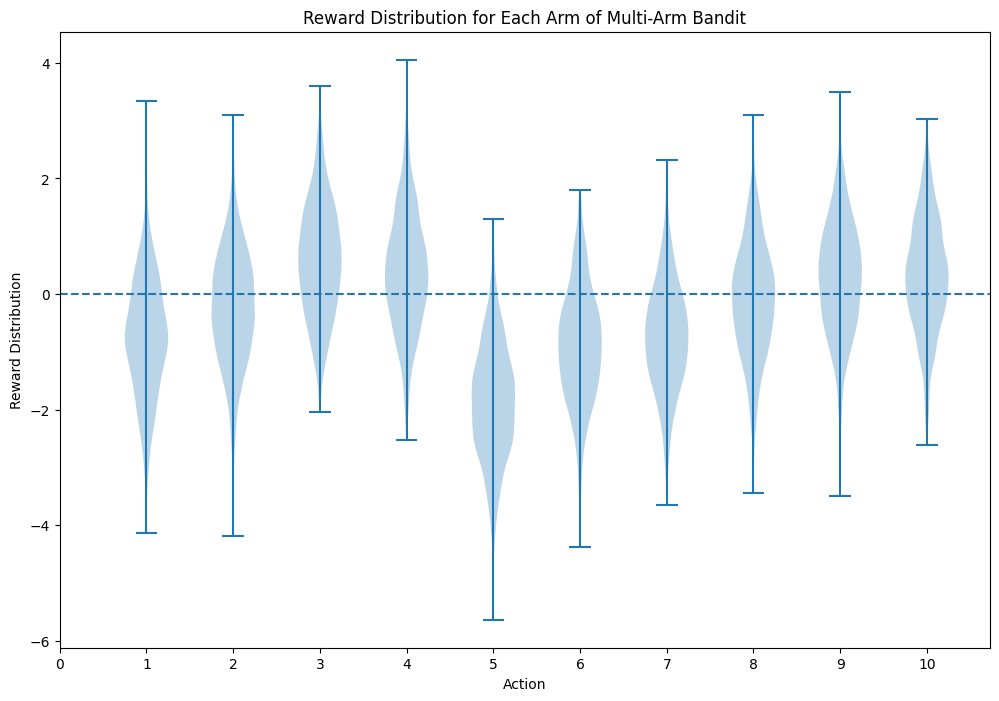

In [169]:
def MultiArmBandit(k: int, num_samples: int):
    """Q4

    Structure:
        1. Create multi-armed bandit env
        2. Pull each arm `num_samples` times and record the rewards
        3. Plot the rewards (e.g. violinplot, stripplot)

    Args:
        k (int): Number of arms in bandit environment
        num_samples (int): number of samples to take for each arm
    """

    env = Bandit(k=k)
    env.reset()

    reward_hist = np.zeros((num_samples, k))
    for sample in range(num_samples):
        for i in range(k):
            reward = env.step(i)
            reward_hist[sample, i] = reward

    return reward_hist

def plot_reward_dist(reward_data):
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.violinplot(reward_data)
    plt.axhline(0, linestyle="--")
    ax.set_xticks(np.arange(0, 11, 1))
    ax.set_title("Reward Distribution for Each Arm of Multi-Arm Bandit")
    ax.set_xlabel("Action")
    ax.set_ylabel("Reward Distribution")
    plt.show()

plot_reward_dist(MultiArmBandit(10, 1000))
    

# Q2: Implement ε-greedy algorithm with incremental update

The following is the scaffolding code for the epsilon-greedy agent. 

    1. Reset function: reset the Q value for each arm/action to be self.init. (e.g., self.init = 0)
    
    2. Choose action: select the arm/action using epsilon-greedy strategy.
    
    3. Update: update the time steps, Q values for k arms/actions and numbers of selecting each arm/action.
    
    4. argmax: find the indices of all maximal values in a numpu array.
    
Please finish the code under "CODE HERE"

In [170]:
class EpsilonGreedyAgent(object):
    def __init__(self, k: int, init: int, epsilon: float) -> None:
        """Epsilon greedy bandit agent

        Args:
            k (int): number of arms
            init (init): initial value of Q-values
            epsilon (float): random action probability
        """
        # Number of the arms. For example, k = 10 for 10-armed Bandit problem
        self.k = k

        # Initial Q value
        self.init = init

        # Epsilon value
        self.epsilon = epsilon

        # Q-values for each arm
        self.Q = None
        # Number of times each arm was pulled
        self.N = None
        # Current total number of steps
        self.t = None

    def reset(self) -> None:
        """Initialize or reset Q-values and counts

        This method should be called after __init__() at least once
        """
        self.Q = self.init * np.ones(self.k, dtype=np.float32)
        self.N = np.zeros(self.k, dtype=int)
        self.t = 0

    def choose_action(self) -> int:
        """Choose which arm to pull

        With probability 1 - epsilon, choose the best action (break ties arbitrarily, use argmax() from above).
        
        With probability epsilon, choose a random action.
        """
        # CODE HERE: please implement the epsilon-greedy strategy to select the action
        sample = np.random.random()

        if sample < self.epsilon:
            # Choose Random Action
            action = np.random.choice(np.arange(self.k))
        
        else:
            action = self.argmax(self.Q)
        
        return action

    def update(self, action: int, reward: float) -> None:
        """Update Q-values and N after observing reward.

        Args:
            action (int): index of pulled arm
            reward (float): reward obtained for pulling arm
        """
        # increase the time step
        self.t += 1
        
        # update the self.N
        self.N[action] += 1
        
        # update self.Q with the incremental update
        self.Q[action] += (1.0 / self.N[action]) * (reward - self.Q[action])


    @staticmethod
    def argmax(arr) -> int:
        """Argmax that breaks ties randomly

        Takes in a list of values and returns the index of the item with the highest value, breaking ties randomly.

        Note: np.argmax returns the first index that matches the maximum, so we define this method to use in EpsilonGreedy and UCB agents.
        Args:
            arr: sequence of values
        """
        arr = np.asarray(arr)
        max_val = arr.max()
        max_indices = np.flatnonzero(arr == max_val)
        return np.random.choice(max_indices)

In [171]:
""" Here is the function to run the epsilon greedy agent. Please complete the missing part under "CODE HERE"
"""
# run epsilon greedy 
def run_epsilon_greedy_agent(run_num, time_step, epsilon=0.0, init=0.0):
    """
    Args:
        run_num (int): number of runs
        time_step (int): number of time steps per run
        epsilon (float): epsilon for the agent
        init (float): initial value for the Q. (i.e., Q1)
    """
    # DO NOT CHANGE: create the 10-armed Bandit problem
    k = 10
    env = Bandit(k)
    env.reset()

    # DO NOT CHANGE: create the agent with proper initial value and epsilon
    agent = EpsilonGreedyAgent(k=k, init=init, epsilon=epsilon)
    agent.reset()

    # DO NOT CHANGE: create a numpy array to store rewards with shape (run_num, time_step)
    # For example, results_rewards[r, t] stores the reward for step t in the r-th running trail
    results_rewards = np.empty((run_num, time_step))
    
    # DO NOT CHANGE: create a numpy array to store optimal action proportion with shape (run_num, time_step)
    # For example, results_action[r, t] stores 1 if the selected action at step t in the r-th runing trail is optimal
    # and 0 otherwise.
    results_action = np.empty((run_num, time_step))
    
    # DO NOT CHANGE: create a numpy array to save upper_bound (only for plotting rewards; it should be 1 for plotting action optimality proportion)
    # For example, upper_bound[r] stores the true action value for the r-th running trail.
    upper_bound = np.empty(run_num)
    

    # loop for trails starts
    for r in tqdm.tqdm(range(run_num), desc="run number", position=0):
        
        # reset the environment to create a new 10-armed bandit problem.
        env.reset()

        # reset the agent
        agent.reset()
        
        # compute the upper bound for each running trial and update upper_bound[r]
        best_action = env.best_action()[0]
        upper_bound[r] = env.q_star[best_action] * time_step # If you took best action at every timestep
        
        # loop for each trail a fixed number of steps
        for t in tqdm.tqdm(range(time_step), desc="time step", position=1, leave=False):
            
            # get the best action to execute at step t 
            action = agent.choose_action()
            
            # interact with the environment to receive rewards
            reward = env.step(action)
                        
            # update the agent based on the observed reward
            agent.update(action, reward)
                     
            """DO NOT CHANGE BELOW"""
            # save the reward
            results_rewards[r, t] = reward
            # check and save whether the action is optimal
            if action in env.best_action():
                results_action[r, t] = 1
            else:
                results_action[r, t] = 0
            
    return results_rewards, results_action, upper_bound

In [ ]:
"""Here is the implementation for running the experiment. You have to run the "run_epsilon_greedy_agent" function
   for multiple times for different parameter combination. Please use smaller run_num and time_step for Debug only.
   For example, run_num = 100, time_step = 100
"""
# always set the random seed for results reproduction
np.random.seed(1234)
random.seed(1234)
    
# set the running parameters (Use 2000 runs and 1000 steps for final report)
run_num = 2000
time_step = 1000

epsilons = [0.0, 0.01, 0.1]

rewards_array_for_first_method = []
upper_bound_for_first_method = []

for epsilon in epsilons:
   result_rewards, result_action, upper_bound = run_epsilon_greedy_agent(run_num, time_step, init=0.0, epsilon=epsilon)
   rewards_array_for_first_method.append(result_rewards)
   upper_bound_for_first_method.append(upper_bound)

rewards_array_for_first_method = np.array(rewards_array_for_first_method)
upper_bound_for_first_method = np.array(upper_bound_for_first_method)
 

run number:   0%|          | 0/200 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

(3, 200, 1000)


[-4.28095452e+00  1.90699013e+00  9.36708307e-01  1.33164338e+00
  4.23584389e-02  1.31429359e-01  1.12517660e-01  9.67745874e-01
 -8.27663772e-01  4.10424838e-01  5.66408509e-01  8.44585061e-01
 -7.91097881e-01  5.73315977e-01 -3.16566494e-01 -9.75212902e-02
  4.41702116e-01 -8.33865658e-01  6.78134530e-01  7.38653805e-01
  3.58751588e+00 -2.35887130e-01 -1.32424214e+00  9.85161651e-03
  1.41269730e+00  1.59701348e+00  6.07591197e-01 -8.13151718e-02
  1.33308343e+00  4.45364108e-01 -1.32497711e+00  3.42980931e-01
  3.07719684e-01 -1.56665027e+00  1.48462618e+00 -5.44677813e-01
  5.05510259e-01 -8.72432903e-01  3.26431812e-01  7.38603750e-01
  1.11438412e+00  5.42516222e-01  1.55088304e+00  3.89658841e-01
  6.20374611e-01  3.37737478e-01  1.86871169e-01  1.20363719e+00
  2.62226540e-01 -4.81752521e-01  5.20448033e-01  4.59312986e-01
 -8.11602522e-01  1.08487123e-01  1.13748057e+00  2.25259409e+00
 -6.60922013e-01  3.58342424e-01  4.85891139e-01  6.36501446e-02
 -1.16685739e+00 -1.03668

<Figure size 640x480 with 0 Axes>

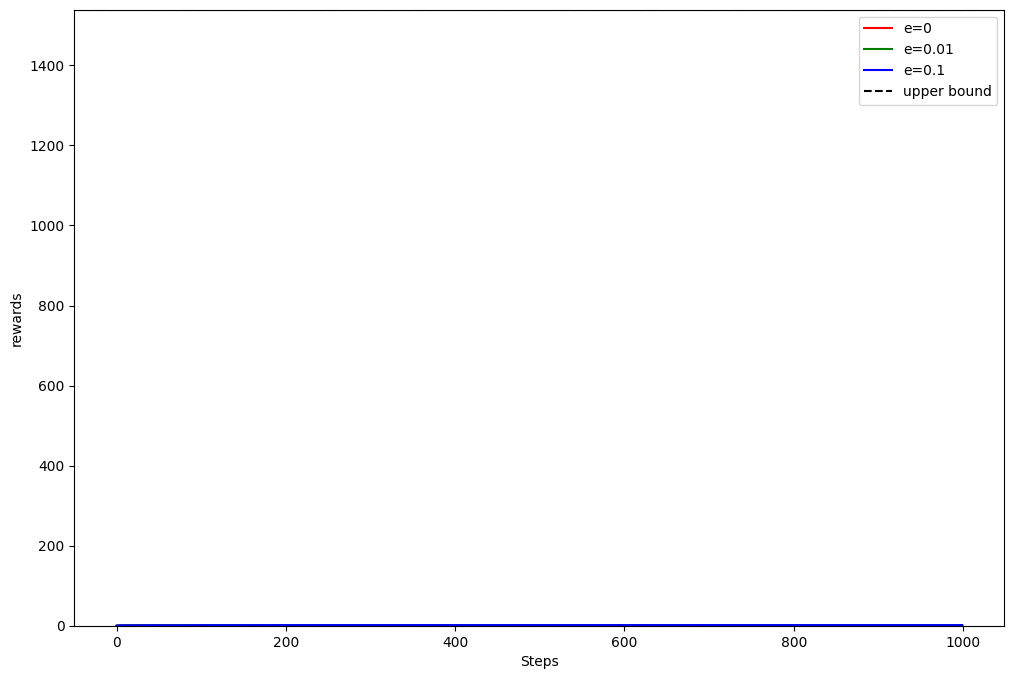

In [175]:
# Plot the "Average reward" figure
plot_curves(rewards_array_for_first_method,
            ["e=0", "e=0.01", "e=0.1"],
            ["r", "g", "b"],
            upper_bound_for_first_method,
            "rewards")

In [174]:
# Plot the "% Optimal action" figure
plot_curves([action_array_for_first_method],
            ["curve legend name for first method"],
            ["curve color for first method"],
            upper_bound_for_first_method, # should be 100%
            "y axis label")

NameError: name 'action_array_for_first_method' is not defined

# Q3: Implement the ε-greedy algorithm with optimistic initial values, and the bandit algorithm with UCB action selection

In [ ]:
""" Reproducing the Figure 2.3.
Please note, instead of using the sample-average technique,
Use equation 2.5 to update the Q values with \alpha=0.1
"""
class EpsilonGreedyAgent(object):
    def __init__(self, k: int, init: int, epsilon: float) -> None:
        """Epsilon greedy bandit agent

        Args:
            k (int): number of arms
            init (init): initial value of Q-values
            epsilon (float): random action probability
        """
        # Number of the arms. For example, k = 10 for 10-armed Bandit problem
        self.k = k

        # Initial Q value
        self.init = init

        # Epsilon value
        self.epsilon = epsilon

        # Q-values for each arm
        self.Q = None
        # Number of times each arm was pulled
        self.N = None
        # Current total number of steps
        self.t = None

    def reset(self) -> None:
        """Initialize or reset Q-values and counts

        This method should be called after __init__() at least once
        """
        self.Q = self.init * np.ones(self.k, dtype=np.float32)
        self.N = np.zeros(self.k, dtype=int)
        self.t = 0

    def choose_action(self) -> int:
        """Choose which arm to pull

        With probability 1 - epsilon, choose the best action (break ties arbitrarily, use argmax() from above).
        
        With probability epsilon, choose a random action.
        """
        # CODE HERE: please implement the epsilon-greedy strategy to select the action
        # return int

    def update(self, action: int, reward: float) -> None:
        """Update Q-values and N after observing reward.

        Args:
            action (int): index of pulled arm
            reward (float): reward obtained for pulling arm
        """
        # increase the time step
        self.t += 1
        
        # CODE HERE: implement the incremental update
        # update the self.N
        
        # CODE HERE: update self.Q with the incremental update
        # Note: For reproducing Figure 2.3, implement the exponential average (equation 2.5)
        # Note: For reproducing Figure 2.4, implement the sample average (equation 2.1)


    @staticmethod
    def argmax(arr) -> int:
        """Argmax that breaks ties randomly

        Takes in a list of values and returns the index of the item with the highest value, breaking ties randomly.

        Note: np.argmax returns the first index that matches the maximum, so we define this method to use in EpsilonGreedy and UCB agents.
        Args:
            arr: sequence of values
        """
        #CODE HERE: implement argmax_a Q(a) for the greedy action selection, breaking ties randomly.

In [ ]:
""" Here is the implementation of the UCB agent. Please complete the missing part.
"""
class UCBAgent(object):
    def __init__(self, k: int, init: int, c: float) -> None:
        """Epsilon greedy bandit agent

        Args:
            k (int): number of arms
            init (init): initial value of Q-values
            c (float): UCB constant that controls degree of exploration
        """
        # Number of the arms. For example, k = 10 for 10-armed Bandit problem
        self.k = k

        # Initial Q value
        self.init = init

        # Epsilon value
        self.c = c

        # Q-values for each arm
        self.Q = None
        # Number of times each arm was pulled
        self.N = None
        # Current total number of steps
        self.t = None

    def reset(self) -> None:
        """Initialize or reset Q-values and counts

        This method should be called after __init__() at least once
        """
        self.Q = self.init * np.ones(self.k, dtype=np.float32)
        self.N = np.zeros(self.k, dtype=int)
        self.t = 0

    def choose_action(self):
        """Choose which arm to pull

        Use UCB action selection. Be sure to consider the case when N_t = 0 and break ties randomly (use argmax() from above)
        """
        # CODE HERE: use UCB to select the action. Be sure to consider the case when N_t = 0
        # and break ties randomly (use argmax() from above). The return should be an integer
        # index of the action.
        # return int


    def update(self, action: int, reward: float) -> None:
        """Update Q-values and N after observing reward.

        Args:
            action (int): index of pulled arm
            reward (float): reward obtained for pulling arm
        """
        # increase the time step
        self.t += 1

        # CODE HERE: implement the incremental update
        # update the self.N

        # CODE HERER: update self.
        # Note: For reproducing Figure 2.3, implement the exponential average (equation 2.5)
        # Note: For reproducing Figure 2.4, implement the sample average (equation 2.1)


In [ ]:
"""Here is the implementation of running the UCB agent. Please complete the missing part.
"""
# run epsilon greedy 
def run_ucb_agent(run_num, time_step, c):
    # create the 10-armed Bandit problem
    k = 10
    env = Bandit(k)
    env.reset()

    # create the agent
    my_agent = UCBAgent(k=k, init=0.0, c=c)
    my_agent.reset()

    # create a numpy array
    results_rewards = np.empty((run_num, time_step))
    
    # create a numpy array
    results_action = np.empty((run_num, time_step))

    # loop starts
    upper_bound = np.empty(run_num)
    for r in tqdm.tqdm(range(run_num), desc="run number", position=0):
       
        # CODE HERE: reset the environment and the agent
        # create a new 10-armed bandit problem
        
        # CODE HERE: create a new agent

        # CODE HERE: update upper_bound[r]

        for t in tqdm.tqdm(range(time_step), desc="time step", position=1, leave=False):
            # CODE HERE: choose action for time step t
            # act = int

            # CODE HERE: interact with the environment
            # reward = float

            # CODE HERE: update the bandit agent with the observed reward

            
            # save the reward
            results_rewards[r, t] = reward
            # compute the optimality
            if act in env.best_action():
                results_action[r, t] = 1
            else:
                results_action[r, t] = 0
            
    return results_rewards, results_action, upper_bound

# Reproduce Figure 2.3 using exponential average (equation 2.5 with alpha = 0.1)

In [ ]:
"""Here is the implementation for running the experiment. You have to run the "run_ucb_agent" function
   for multiple times for different parameter combination. Please use smaller run_num and time_step for Debug only.
   For example, run_num = 100, time_step = 1000
"""
# set the running parameters
run_num = 2000 
time_step = 1000
    
# CODE HERE: 
# 1. Run the epsilon-greedy agent experiment for initial value = 0.0, epsilon = 0.0
# 2. Run the epsilon-greedy agent experiment for initial value = 5.0, epsilon = 0.0 
# 3. Run the epsilon-greedy agent experiment for initial value = 0.0, epsilon = 0.1 
# 4. Run the epsilon-greedy agent experiment for initial value = 5.0, epsilon = 0.1 
# 5. Run the UCB agent experiment for c=2

In [ ]:
# Plot the "% Optimal action" figure
plot_curves([action_array_for_first_method],
            ["curve legend name for first method"],
            ["curve color for first method"],
            upper_bound_for_first_method, # should be 100%
            "y axis label")

# Reproduce Figure 2.4 using sample average (equation 2.1)

In [ ]:
"""Here is the implementation for running the experiment. You have to run the "run_ucb_agent" function
   for multiple times for different parameter combination. Please use smaller run_num and time_step for Debug only.
   For example, run_num = 100, time_step = 1000
"""
# always set the random seed for results reproduction
np.random.seed(1234)
random.seed(1234)

# set the number of run
run_num = 2000
# set the number of time steps
time_step = 1000

# CODE HERE: 
# 1. Run the epsilon-greedy agent experiment for initial value = 0.0, epsilon = 0.0
# 2. Run the epsilon-greedy agent experiment for initial value = 5.0, epsilon = 0.0 
# 3. Run the epsilon-greedy agent experiment for initial value = 0.0, epsilon = 0.1 
# 4. Run the epsilon-greedy agent experiment for initial value = 5.0, epsilon = 0.1 
# 5. Run the UCB agent experiment for c=2

In [ ]:
# Plot the "Average reward" figure
plot_curves([rewards_array_for_first_method],
            ["curve legend name for first method"],
            ["curve color for first method"],
            upper_bound_for_first_method,
            "y axis label")